In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from fd_analysis.prepare import filter_corrupt_files, get_python_projects, get_code_dirs,get_depsfiles, reduce_directory_levels
from fd_analysis.explore import codedirs_per_filetype, get_dependencies_declaration
import matplotlib
from matplotlib.font_manager import fontManager


font_path ='/usr/share/fonts/Virgil.ttf' 

# Register the font
fontManager.addfont(font_path)

font = {"family":"Virgil 3 YOFF"}
matplotlib.rc("font", **font)

## Import data

In [134]:
# import Biomedical's data
paths_biomed = "../data/results_biomed_20240423"
raw_data_biomed, corrupt_biomed = filter_corrupt_files([Path(paths_biomed) / file for file in os.listdir(paths_biomed)])
if not corrupt_biomed:
    print("Biomedical data OK")
else:
    print(f"Corrupt data ({len(corrupt_biomed)}) projects: ", corrupt_biomed)

# import PyPi data
paths_pypi = "../data/results_pypi_20240423"
raw_data_pypi, corrupt_pypi = filter_corrupt_files([Path(paths_pypi) / file for file in os.listdir(paths_pypi)])
if not corrupt_pypi:
    print("PyPi data OK")
else:
    print(f"Corrupt data ({len(corrupt_pypi)}) projects: ", corrupt_pypi)

Biomedical data OK
PyPi data OK


## Filter data: include Python projects only

In [135]:
python_projects_biomed = get_python_projects(raw_data_biomed) 
data_biomed = {k:v for k, v in raw_data_biomed.items() if v["metadata"]["project_name"] in python_projects_biomed}
print(f"Number of biomedical Python projects {len(python_projects_biomed)} out of {len(raw_data_biomed)} total.")

python_projects_pypi = get_python_projects(raw_data_pypi)
data_pypi = {k:v for k, v in raw_data_pypi.items() if v["metadata"]["project_name"] in python_projects_pypi}
print(f"Number of PyPi Python projects {len(python_projects_pypi)} out of {len(raw_data_pypi)} total.")

Number of biomedical Python projects 1260 out of 1818 total.
Number of PyPi Python projects 1118 out of 1160 total.


In [136]:
#  Get projects from PyPi that are not markes as Python projects

# Note: some of them are archived, some of them do not require external dependencies
{v["metadata"]["repo_url"] for k,v in data_pypi.items() if v["metadata"]["project_name"] not in python_projects_pypi}

set()

## Format data

In [137]:
pypi_codedirs_df = get_code_dirs(data_pypi)
biomed_codedirs_df = get_code_dirs(data_biomed)


pypi_only_py_df, pypi_only_ipynb_df = codedirs_per_filetype(pypi_codedirs_df)
biomed_only_py_df, biomed_only_ipynb_df = codedirs_per_filetype(biomed_codedirs_df)

# dependency files
biomed_deps = get_depsfiles(data_biomed)
pypi_deps = get_depsfiles(data_pypi)

732
1117


## Project types

In [138]:
project_stats = dict()

In [139]:
def get_n_projects_with_declaration(data, matched_projects, verbose = True ):
    if verbose:
        n_matched_projects = len(matched_projects)
        n_projects = len(data)
        print(f"Number of projects: {n_matched_projects} out of {n_projects} total, {round(len(matched_projects) / n_projects * 100, 2)} %")
    # display(matched_projects.head(10))
    deps_declaration_soup = [len(get_dependencies_declaration(v["deps_file"]))>0 
                                for v in data.values()
                            if v["metadata"]["project_name"] in set(matched_projects.index)]
    if verbose and n_matched_projects > 0:
        print(f"Percent of projects that have declaration: {round(sum(deps_declaration_soup) / len(matched_projects) * 100, 2)} %")
    return sum(deps_declaration_soup)

### Baseline - all projects

In [140]:

def get_all_projects(codedirs_py, codedirs_ipynb, data_python, verbose=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''
    
    matched_projects = (codedirs_py + codedirs_ipynb).dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_projects_with_declaration = get_n_projects_with_declaration(data_python, matched_projects, verbose)
    return {"all": len(data_python), "matched": len(matched_projects), "with declaration":n_projects_with_declaration}


In [141]:
project_stats["all"] = {"pypi": get_all_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi),
                        "biomed": get_all_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)}

Number of projects: 1118 out of 1118 total, 100.0 %
Percent of projects that have declaration: 83.36 %
Number of projects: 1260 out of 1260 total, 100.0 %
Percent of projects that have declaration: 50.63 %


### Soup projects

In [142]:
# identify project type 
def get_soup_projects(codedirs_py, codedirs_ipynb, data_python, verbose=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    cond = (
        ((codedirs_ipynb['.'] > 0) | (codedirs_py['.'] > 0)) & 
        (codedirs_py.drop('.', axis=1).sum(axis=1) == 0) & 
        (codedirs_ipynb.drop('.', axis=1).sum(axis=1) == 0))
    
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_projects_with_declaration = get_n_projects_with_declaration(data_python, matched_projects, verbose)
    return {"all": len(data_python), "matched": len(matched_projects), "with declaration":n_projects_with_declaration}

In [143]:
project_stats["soup"] = {"pypi": get_soup_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi),
                        "biomed": get_soup_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)}

Number of projects: 29 out of 1118 total, 2.59 %
Percent of projects that have declaration: 55.17 %
Number of projects: 205 out of 1260 total, 16.27 %
Percent of projects that have declaration: 18.05 %


### SRC project

In [144]:
# identify project type 
def get_src_projects(codedirs_py, codedirs_ipynb, data_python, verbose=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    ipynb_columns = [col for col in codedirs_ipynb.columns if 'src' in col]
    py_columns = [col for col in codedirs_py.columns if 'src' in col]
    cond = ((codedirs_ipynb[ipynb_columns].sum(axis=1) > 0) | 
            (codedirs_py[py_columns].sum(axis=1) > 0))
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_projects_with_declaration = get_n_projects_with_declaration(data_python, matched_projects, verbose)
    return {"all": len(data_python), "matched": len(matched_projects), "with declaration":n_projects_with_declaration}

In [145]:
project_stats["src"] = {"pypi": get_src_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi),
                        "biomed": get_src_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)}

Number of projects: 220 out of 1118 total, 19.68 %
Percent of projects that have declaration: 88.64 %
Number of projects: 134 out of 1260 total, 10.63 %
Percent of projects that have declaration: 64.93 %


### Project with the same name

In [146]:
# identify project type 
def get_same_name_projects(codedirs_py, codedirs_ipynb, data_python, verbose=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    ipynb_columns = [col for col in codedirs_ipynb.columns if 'PROJECT_NAME' in col]
    py_columns = [col for col in codedirs_py.columns if 'PROJECT_NAME' in col]
    cond = ((codedirs_ipynb[ipynb_columns].sum(axis=1) > 0) | 
            (codedirs_py[py_columns].sum(axis=1) > 0))
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_projects_with_declaration = get_n_projects_with_declaration(data_python, matched_projects, verbose)
    return {"all": len(data_python), "matched": len(matched_projects), "with declaration":n_projects_with_declaration}

In [147]:
project_stats["same name"] = {"pypi": get_same_name_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi),
                        "biomed": get_same_name_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)}

Number of projects: 434 out of 1118 total, 38.82 %
Percent of projects that have declaration: 82.95 %
Number of projects: 342 out of 1260 total, 27.14 %
Percent of projects that have declaration: 83.33 %


### Projects with test

In [148]:

# identify project type 
def get_test_projects(codedirs_py, codedirs_ipynb, data_python, verbose=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    ipynb_columns = [col for col in codedirs_ipynb.columns if 'test' in col]
    py_columns = [col for col in codedirs_py.columns if 'test' in col]
    cond = ((codedirs_ipynb[ipynb_columns].sum(axis=1) > 0) | 
            (codedirs_py[py_columns].sum(axis=1) > 0))
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_projects_with_declaration = get_n_projects_with_declaration(data_python, matched_projects, verbose)
    return {"all": len(data_python), "matched": len(matched_projects), "with declaration":n_projects_with_declaration}

In [149]:
project_stats["test"] = {"pypi": get_test_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi),
                        "biomed": get_test_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)}

Number of projects: 948 out of 1118 total, 84.79 %
Percent of projects that have declaration: 87.24 %
Number of projects: 445 out of 1260 total, 35.32 %
Percent of projects that have declaration: 84.94 %


###

### Analytical projects

In [150]:

# identify project type 
def get_analytical_projects(codedirs_py, codedirs_ipynb, data_python, verbose=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    cond = ((codedirs_ipynb.sum(axis=1) > 5) & 
            (codedirs_py.sum(axis=1) <5))
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all')
    if len(matched_projects) > 0:
        matched_projects.sort_values(by='.', ascending=False, inplace=True)
    n_projects_with_declaration = get_n_projects_with_declaration(data_python, matched_projects, verbose)
    return {"all": len(data_python), "matched": len(matched_projects), "with declaration":n_projects_with_declaration}

In [151]:
project_stats["analytical"] = {"pypi": get_analytical_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi),
                        "biomed": get_analytical_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)}

Number of projects: 0 out of 1118 total, 0.0 %
Number of projects: 106 out of 1260 total, 8.41 %
Percent of projects that have declaration: 16.98 %


In [152]:
project_stats

{'all': {'pypi': {'all': 1118, 'matched': 1118, 'with declaration': 932},
  'biomed': {'all': 1260, 'matched': 1260, 'with declaration': 638}},
 'soup': {'pypi': {'all': 1118, 'matched': 29, 'with declaration': 16},
  'biomed': {'all': 1260, 'matched': 205, 'with declaration': 37}},
 'src': {'pypi': {'all': 1118, 'matched': 220, 'with declaration': 195},
  'biomed': {'all': 1260, 'matched': 134, 'with declaration': 87}},
 'same name': {'pypi': {'all': 1118, 'matched': 434, 'with declaration': 360},
  'biomed': {'all': 1260, 'matched': 342, 'with declaration': 285}},
 'test': {'pypi': {'all': 1118, 'matched': 948, 'with declaration': 827},
  'biomed': {'all': 1260, 'matched': 445, 'with declaration': 378}},
 'analytical': {'pypi': {'all': 1118, 'matched': 0, 'with declaration': 0},
  'biomed': {'all': 1260, 'matched': 106, 'with declaration': 18}}}

Type: all


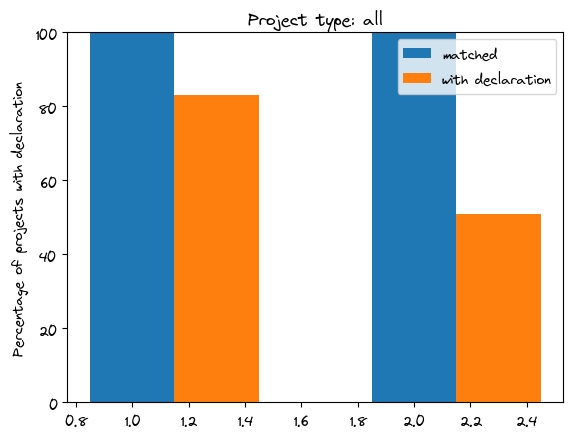

Type: soup


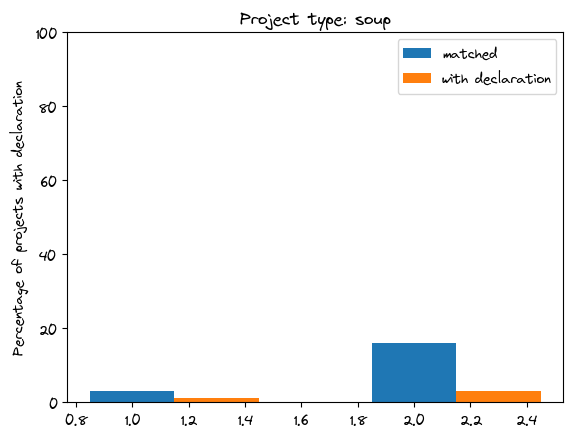

Type: src


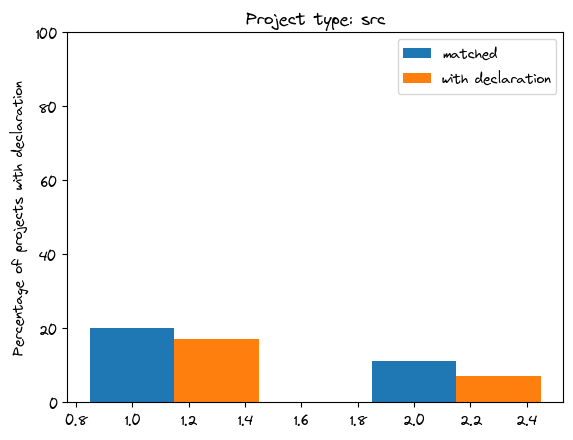

Type: same name


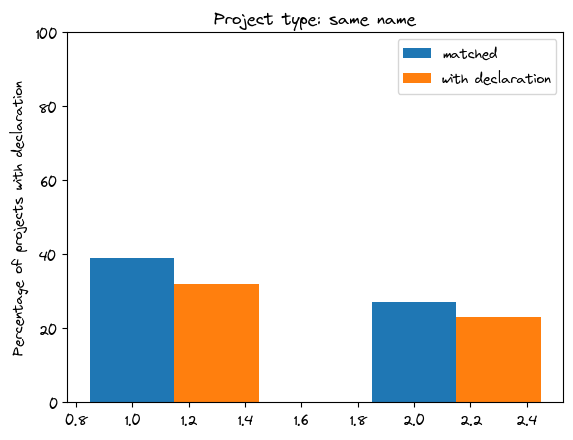

Type: test


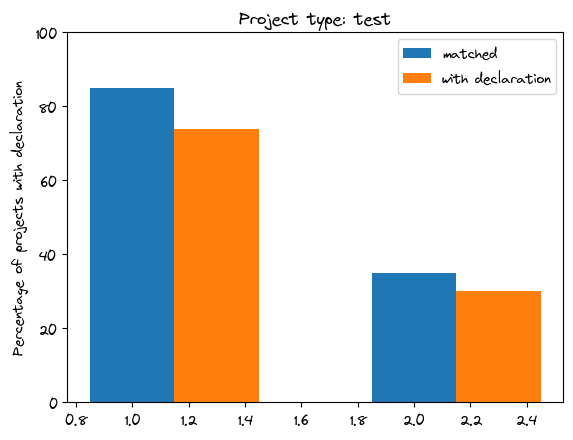

Type: analytical


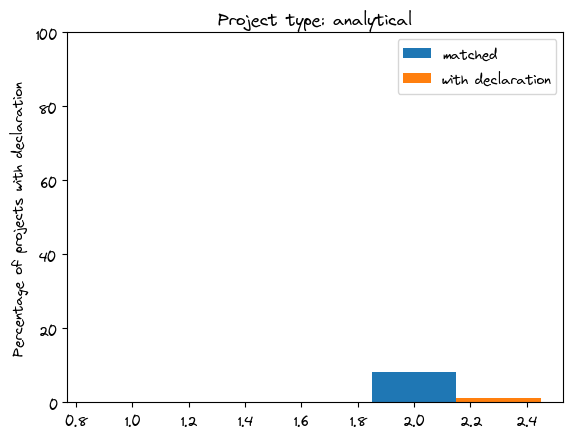

In [156]:
for k, v in project_stats.items():
    print(f"Type: {k}")
    plt.title(f"Project type: {k}")
    plt.ylabel("Percentage of projects with declaration")
    plt.ylim(0, 100)
    xlabels = ["PyPi", "biomed"]
    width = 0.3
    plt.bar([1, 2],
            [np.round(v["pypi"]["matched"]/v["pypi"]["all"] * 100), np.round(v["biomed"]["matched"]/v["biomed"]["all"] *100)],
            width=width, label="matched")
    plt.bar([1+width, 2+width],
            [np.round(v["pypi"]["with declaration"]/v["pypi"]["all"] * 100), np.round(v["biomed"]["with declaration"]/v["biomed"]["all"] *100)],
            label="with declaration", width=width)
    plt.legend()
    plt.show()